In [1]:
import mlflow
from mlflow.tracking.client import MlflowClient

from rich import print
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import ray
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from ddistexps.utils import format_vertical_headers

# sns.set_theme(style="whitegrid")  
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

[2024-05-06 17:01:15,869] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


# Accuracy conditioned on Score: Calibration

We check if the models on the pareto frontier are calibrated.

[A blog intro](https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html.)



In [2]:
# Define the relevant experiments here; Dataset -> [Experiment names]
EXPERIMENTS = {
    'CIFAR10': {
        'expnames': ['baseline/cifar10-small', 'baseline/cifar10-large',
        'distillation/cifar10-small'],
        'ds_kwargs': {'ds_name': 'CIFAR10Eval'},
        'worker_resource_req': {'num_gpus': 0.33},
    },
    #'CIFAR100': ['baseline/cifar100-small', 'baseline/cifar100-large', 'distillation/cifar100-small'],
    'ImageNet1k': {
        'expnames': ['baseline/imagenet-small', 'baseline/imagenet-sanity'],
        'ds_kwargs': {'ds_name': 'ImageNet1kEval'},
        'worker_resource_req': {'num_gpus': 0.33},
    },
    'TinyImageNet': [],
}

In [3]:
from ccutils.utils import get_all_runs, get_pareto_frontier, NDict
from ccutils.inference import get_run_predictions
from ccutils.plot import plot_pareto_curve

num-runs: 271
metrics.val_acc_best      0
metrics.artifact_flops    0
dtype: int64
num-runs: 154
metrics.val_acc_best      5
metrics.artifact_flops    0
dtype: int64


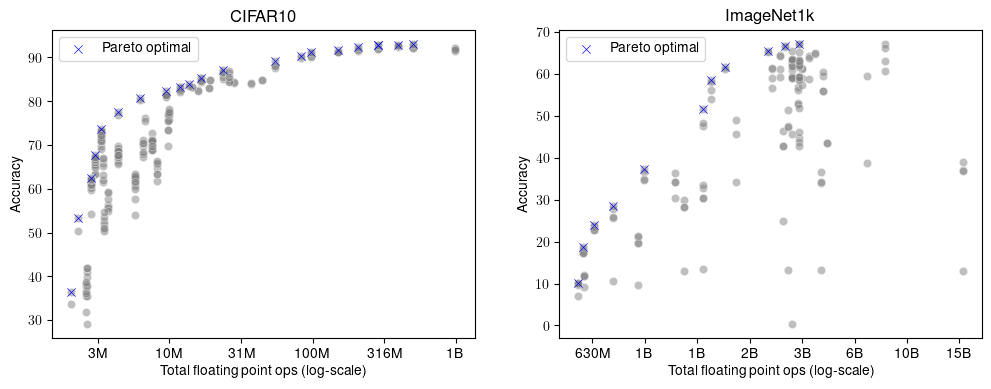

In [4]:
all_ds_names = ['CIFAR10', 'ImageNet1k']
fig, axs = plt.subplots(1, len(all_ds_names), figsize=(12, 4))
for ds_name in all_ds_names:
    expnames = EXPERIMENTS[ds_name]['expnames']
    all_runs = get_all_runs(expnames)
    plot_pareto_curve(ds_name, all_runs, ax=axs[all_ds_names.index(ds_name)])

In [5]:
from ddist.utils import tqdm_ray_wait
ray.init(namespace='DataFlow', ignore_reinit_error=True, log_to_driver=False)


2024-05-06 17:01:26,609	INFO worker.py:1432 -- Using address localhost:4004 set in the environment variable RAY_ADDRESS
2024-05-06 17:01:26,615	INFO worker.py:1567 -- Connecting to existing Ray cluster at address: 104.171.203.248:4004...
2024-05-06 17:01:26,697	INFO worker.py:1743 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.10.0', ray_commit='09abba26b5bf2707639bb637c208d062a47b46f6')

# Score conditioned Accuracy and Density

- $x$-axis: Score $\theta$
- $y$-axis: Accuracy $f_\text{acc}(\theta) = 100\cdot P( y \ne h(x) \mid s(x) = \theta) $
- $y$-axis: Density $f_{\text{density}}(\theta) = 100\cdot P(s(x) = \theta) $

In [6]:
# 1. Get all the runs for pareto frontier and get all their predictions.
# 2. Compute the two functions for each run.
# 3. Plot the two functions on separate plot. Add the run-accuracy as the legend.

ds_names = ['CIFAR10', 'ImageNet1k']
results_buffer = {}
for ds_name in ds_names:
    print(ds_name)
    all_runs = get_all_runs(EXPERIMENTS[ds_name]['expnames'])
    pareto_runs = get_pareto_frontier(all_runs)
    futs = [get_run_predictions(run_id, EXPERIMENTS) for run_id in pareto_runs['run_id'].values]
    tqdm_ray_wait(futs)
    results = [ray.get(f) for f in futs]
    pareto_runs['result'] = results
    results_buffer[ds_name] = pareto_runs

CIFAR10

num-runs: 271
metrics.val_acc_best      0
metrics.artifact_flops    0
dtype: int64


 0:   0%|          | 0/21 [00:00<?, ?it/s]

ImageNet1k

num-runs: 154
metrics.val_acc_best      5
metrics.artifact_flops    0
dtype: int64


 0:   0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
def unpack_result(result):
    """Converts the results array into a dataframe"""
    def score_to_bin_id(score):
        assert 0 <= score <= 1
        # Divides into 100 equal width bins
        return int(score * 100)
    
    rdf = pd.DataFrame({'score': result[:, 0], 'prediction': result[:, 1],
                        'correct': result[:, 2],
                        'is_correct': result[:, 1] == result[:, 2]})
    rdf['bin-id'] = rdf['score'].map(score_to_bin_id)
    return rdf

"""
We construct a nested data frame; the outer dataframe is just the runs. It
has a entry called 'results' which is the numpy array of predictions 
converted to a dataframe.
"""
for ds_name, pareto_runs in results_buffer.items():
    pareto_runs['result'] = pareto_runs['result'].map(unpack_result)
    pareto_runs['measured-acc'] = pareto_runs['result'].map(lambda df: df['is_correct'].mean() * 100.0)


In [8]:
from ccutils.plot import plot_score_vs_score_conditioned_acc

CIFAR10

ImageNet1k

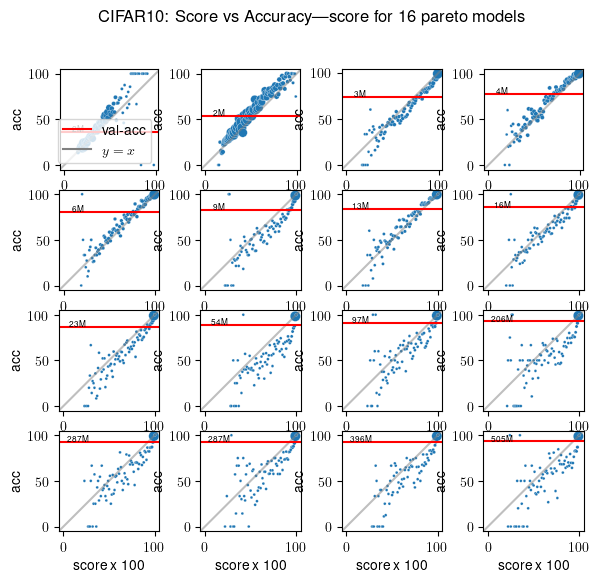

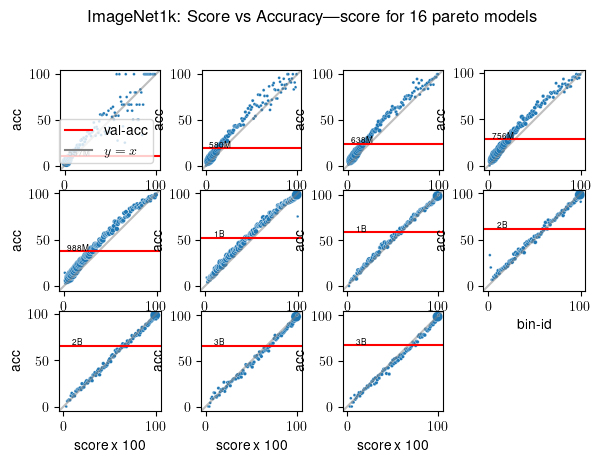

In [9]:
for ds_name, pareto_runs in results_buffer.items():
    print(ds_name)
    fig = plot_score_vs_score_conditioned_acc(ds_name, pareto_runs)
    fig.savefig(f'../imgs/score-vs-acc-{ds_name}.pdf', bbox_inches='tight')

- Small models seem to be highly calibrated. You start loosing calibration as
  the model sizes increase.

TODO: Complete large model runs for ImageNet.

# Cummulative Calibration Curve